In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
import torchvision.utils

import time

latent_dims = 16
num_epochs = 200
batch_size = 128
channels = 64
color_channels = 3
learning_rate = 1e-3
use_gpu = True

img_width = 32 
img_height = 32
img_size = img_width*img_height

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
device

/home/marco/miniconda3/envs/pdl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=0)

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST, MNIST, CIFAR10

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = CIFAR10(root='~/data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10(root='~/data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


# Full Covariance

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        f = channels
        # self.fc_1 = nn.Linear(in_features=img_size, out_features=50)
        self.conv1 = nn.Conv2d(in_channels=color_channels, out_channels=f, kernel_size=4, stride=2, padding=1) # out = fx16x16
        self.conv2 = nn.Conv2d(in_channels=f, out_channels=f*2, kernel_size=4, stride=2, padding=1) # out = fx8x8
        self.fc_mu = nn.Linear(in_features=f*2*8*8, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=f*2*8*8, out_features=latent_dims**2) 
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten image matrix to image vector
        x_mu = self.fc_mu(x)
        x_cov = F.softplus(self.fc_logvar(x))
        
        return x_mu, x_cov
        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        f = channels
        self.fc_1 = nn.Linear(in_features=latent_dims, out_features=f*2*8*8)
        self.conv1 = nn.ConvTranspose2d(in_channels=f*2, out_channels=f, kernel_size=4, stride=2, padding=1) # out = f
        self.conv2 = nn.ConvTranspose2d(in_channels=f, out_channels=color_channels, kernel_size=4, stride=2, padding=1)
        
        
    def forward(self, x):
        x = self.fc_1(x)
        x = x.view(x.size(0), channels*2, 8, 8) # unflatten
        x = F.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        return x   
    

class FullCovarianceAutoencoder(nn.Module):
    def __init__(self):
        super(FullCovarianceAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.loss_mse = torch.nn.MSELoss(reduction='none')
        
    def forward(self, x):
        mu_latent, cov_latent = self.encoder(x)
        
        cov_latent = cov_latent.view(cov_latent.size(0), latent_dims, latent_dims)
        cov_latent_tril = torch.tril(cov_latent)
        latent = dist.multivariate_normal.MultivariateNormal(loc=mu_latent, scale_tril=cov_latent_tril).rsample()
        
        x_reconstruction = self.decoder(latent)
        
        return x_reconstruction, mu_latent, cov_latent
    
        
    def loss(self, pred, target):
        return torch.mean(torch.sum(self.loss_mse(pred, target), dim=-1))

cvae = FullCovarianceAutoencoder()
cvae.to(device)

num_params = sum(p.numel() for p in cvae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 2636307


# Training

Training...
Epoch [1 / 200] average reconstruction error: 0.742754
Epoch [6 / 200] average reconstruction error: 0.536760
Epoch [11 / 200] average reconstruction error: 0.524158
Epoch [16 / 200] average reconstruction error: 0.517389
Epoch [21 / 200] average reconstruction error: 0.513660
Epoch [26 / 200] average reconstruction error: 0.511254
Epoch [31 / 200] average reconstruction error: 0.509393
Epoch [36 / 200] average reconstruction error: 0.508008
Epoch [41 / 200] average reconstruction error: 0.506779
Epoch [46 / 200] average reconstruction error: 0.505585
Epoch [51 / 200] average reconstruction error: 0.504618
Epoch [56 / 200] average reconstruction error: 0.503712
Epoch [61 / 200] average reconstruction error: 0.503211
Epoch [66 / 200] average reconstruction error: 0.502575
Epoch [71 / 200] average reconstruction error: 0.501978
Epoch [76 / 200] average reconstruction error: 0.501605
Epoch [81 / 200] average reconstruction error: 0.501031
Epoch [86 / 200] average reconstructio

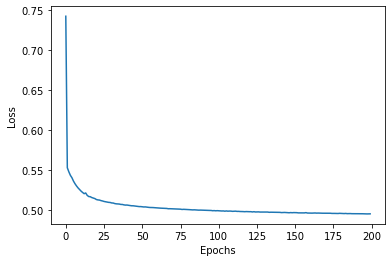

In [4]:
optimizer = torch.optim.Adam(params=cvae.parameters(), lr=learning_rate, weight_decay=1e-5)
cvae.train()
train_loss_avg = []

print("Training...")
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        image_batch = image_batch.to(device)
        
        image_batch_reconstruction, mu_latent, logvar_latent = cvae(image_batch)
        loss = cvae.loss(image_batch_reconstruction, image_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_avg[-1] += loss.item()
        num_batches+=1
    train_loss_avg[-1] /= num_batches
    if (epoch % 5 == 0):
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
        
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Evaluation

In [5]:
# set to evaluation mode
cvae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.squeeze().to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = cvae(image_batch)

        # reconstruction error
        loss = cvae.loss(image_batch_recon, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.529830


# Visualize

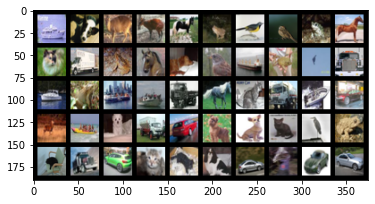

Mean field VAE reconstruction:


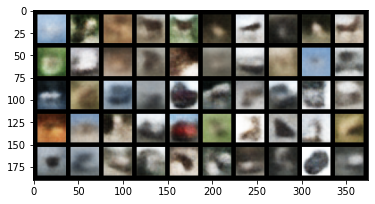

In [61]:
def gallery(images, ncols = 10):
    nindex, height, width = images.shape
    nrows = nindex//ncols
    # assert nindex == nrows*ncols
    result = (images.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    return result

        
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model, color=False):
    with torch.no_grad():
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        
        
        if not color:        
            np_imagegrid = gallery( torchvision.utils.make_grid(images[1:51], 10, 5).numpy())
        else:
            np_imagegrid = torchvision.utils.make_grid(images[1:51], 10, 5)
            show_image(np_imagegrid)
            plt.show()
        
        
        # plt.imshow()
        # plt.show()
        
plt.ion()

images, labels = iter(test_dataloader).next()

cvae.eval()

# First visualise the original images
imgs = torchvision.utils.make_grid(images[1:51],10,5)
show_image(imgs)
plt.show()


# Reconstruct and visualise the images using the vae
print('Mean field VAE reconstruction:')
visualise_output(images, cvae, color=True)